In [ ]:
import methods
import numpy as np
import scipy.linalg as lin
from datetime import datetime
import copy
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

stem0 = '/Users/samuelbegg/'
stem = stem0  + 'Documents/Sensing/'
num_cores = -1 #number of cores for parallelization

# System parameters for periodic boundary condition spin chain
J = 1.0         # +ve is Ferromagnet [Hamiltonian as defined Mishra, Bayat, PRL 127, 080504 (2021)]
gamma = 1.0     # J(1+gamma)XX + J(1-gamma)YY (ignoring other factors, see paper or notes for defn.)
sites = 6       # system size, pick even N as odd N is not verified (pi or -pi mode becomes special)
h1_amp = 1.0    # amplitude of the drive for periodic transverse field
h1_period = 1.0 # period of the drive for periodic transverse field
h0 = 0.1        # static transverse field

# Initial state
initial_state = 'ground_state' 
# 'ground_state': starts in the system ground-state. 
# 'random_state': every momenta has a random up or down state in BdG eigenbasis
# 'BdG_vacuum':   all spins down in BdG eigenbasis

# Other options which may require some recoding for compatibility with the stroboscopic code
        # 'flips': manually flips specific spins (with the rest down), see below. Default: single flip. Odd number of excitations (spin) = even parity (fermions) = PBC. 
        # 'momentum': a k = 0 momentum state. Even parity = PBC.
        # 'spin_up': all spins up, odd number excitations (spin) = even parity = PBC, even number excitations (spin) = odd parity (fermions) = ABC

# Boundary conditions
boundary_conditions = 'PBC' 
# 'PBC' = periodic boundary conditions or 'ABC' = anti-periodic boundary conditions
# The boundary conditions must reflect the fermion parity in the initial conditions (see above).
# The Fourier transform definition is automatically adjusted based on number sites and boundary conditions, as in arXiv:1707.02400.

# Time parameters 
dt = 0.0001                         # time step for integration
oneperiod_steps = int(h1_period/dt) # number of steps in one period, make sure this is integer.
final_time = 6                    # final time in stroboscopic units (return results at stroboscopic times up to this time)

# Initialize the periodic field and its midpoint for each time-step (to be used by integration scheme)
h1 = h1_amp*np.sin(2*np.pi/(h1_period)*dt*np.arange(0,oneperiod_steps)) # initialize periodic field
h1_midpoint = h1_amp*np.sin(2*np.pi/(h1_period)*dt*(0.5 + np.arange(0,oneperiod_steps))) # vector at the mid-point between time-steps, required for RK4 due to explicit time-dependance

if sites % 2 != 0:
    print("Warning: Odd number of sites — BdG k,-k pairing will be incomplete.")


Calculate the eigenvalues and state of the Floquet unitary

In [97]:
# Calculate state after 1 period starting from a basis state. This is used to build Floquet unitary.
particle_number = []
quasi_energy = []
initial_state_list = []
eval_list = []
evec_list = []

basis_state = []
for kk in range(0,sites):

    basis_state = basis_state + [np.asarray([1.0,0.0],dtype=complex)] #basis state is up (occupied state), initial down-state used in method

method = 'RK4' # integration method 'heun' or 'RK4' (best to go for very high accuracy/small steps as only integrate 1 period.)
# integrate basis state
#state = methods.integrator_BdG(J, gamma, h0, h1, h1_midpoint, oneperiod_steps, dt, sites, boundary_conditions, basis_state, method)
state = methods.integrate_bdg_eff(basis_state, h1_amp, h1_period, J, gamma, h0, dt, oneperiod_steps, sites, boundary_conditions)
# Initial state is a list of vectors (u_k,v_k) 
# Build the Floquet unitary and calculate eigenvalues, eigenvectors in this basis
eval, evec = methods.floquet_eigsystem(state)

print('Eigensystem evaluated')

# Calculate the initial ground-state, replace for other initial states
if initial_state == "ground_state":

    initial_state = methods.initial_BdG(J, gamma, h0, h1, sites, boundary_conditions)

elif initial_state == "random_state":
    
    initial_state = methods.random_state(sites) # every spin random up or down (will be interpreted as BdG diagonal basis up and down) 
    #initial_state = methods.position_to_momentum(sites, boundary_conditions, initial_state) # convert to momentum space

elif initial_state == "BdG_vacuum":

    initial_state = methods.BdG_vacuum(sites) # BdG vacuum state, all spins down in BdG eigenbasis

initial_state_list = initial_state_list + [initial_state]

eval_list = eval_list + [eval]
evec_list = evec_list + [evec]
eval_list = np.array(eval_list)
evec_list = np.array(evec_list)
initial_state_list = np.array(initial_state_list)
particle_number = []
sigma_Xsq = []

for time in range(0,final_time):
    print(f"time step: {time}")

    obs, Dag_obs, _ = methods.floquet_evolution_eff_vectorized(
        time,
        sites,
        boundary_conditions,
        eval_list,         # shape (1, sites, 2)
        evec_list,         # shape (1, sites, 2, 2)
        initial_state_list # shape (1, sites, 2)
    )

    # obs: shape (1, sites, sites) local observables at time t
    # Dag_obs: shape (1, sites, sites) local observables at time t

    # Z ~ particle number , <n_jj> = <c^{dag}_jj c_jj>, can also access general <c^{dag}_jj c_kk> if desired
    jj = 0 # example
    particle_number.append(obs[0, jj, jj])

    # X^2 = (c_j^dag + c_j)^2 = 1 + <c^{dag}_jj c{dag}_jj> + <c_jj c_jj>. 
    sigma_Xsq.append(obs[0, jj, jj+1] + np.conj(obs[0, jj, jj+1]) +  Dag_obs[0, jj, jj+1] + np.conj(Dag_obs[0, jj, jj+1]))


Eigensystem evaluated
time step: 0
time step: 1
time step: 2
time step: 3
time step: 4
time step: 5


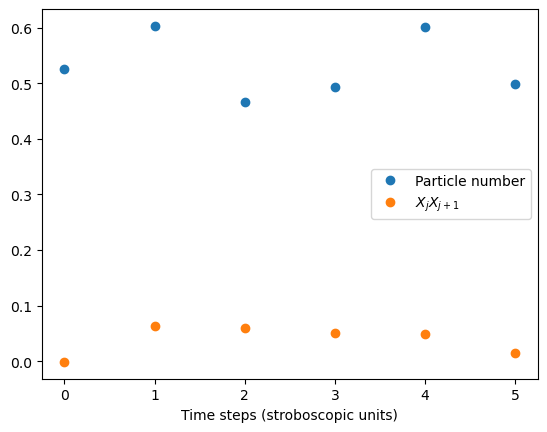

In [98]:
plt.plot(np.arange(0,final_time),particle_number, "o", label='Particle number')
plt.plot(np.arange(0,final_time),sigma_Xsq, "o", label=r'$X_j X_{j+1} $') #(pauli matrices NOT spin operators! rescale by 1/2 per X to convert)
plt.xlabel('Time steps (stroboscopic units)')
plt.legend()
plt.show()


check against the brute force evaluation to final time (not stroboscopic)

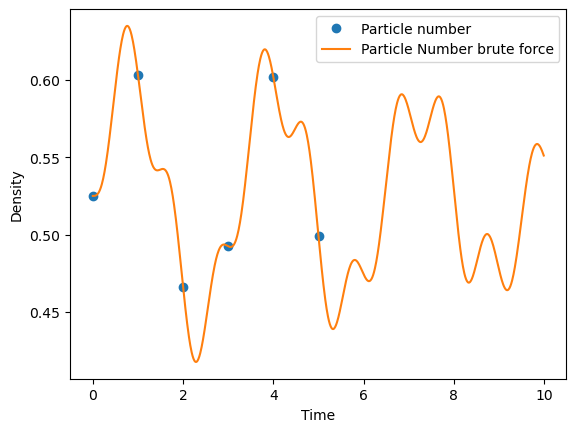

(6,)


In [99]:
# If you want to check stroboscopic code is working you can compare with brute force results using... 
# ... XY_time_evolution.ipynb which does integration of correlation matrices in position space
# AND if you want to compare to a spin system, the code matrix_integrator.py integrates small systems (no approximation). It is a bad integrator though so use small steps, it is just intended to check this code is working
# when comparing to the spin system you will need to get the boundary conditions of the fermionic system correct. This depends on number of spin excitations. For the random up/down just count number of up spins.

particle_number_bruteforce = np.load('Results/density.npy')
pair_creation_bruteforce   = np.load('Results/pair_creation.npy')
measure_tvec    = np.load('Results/measure_tvec.npy')

plt.plot(h1_period * np.arange(0,final_time),particle_number, "o", label='Particle number')
plt.plot(measure_tvec, particle_number_bruteforce[0,0,:], label='Particle Number brute force')
plt.xlabel('Time')
plt.ylabel('Density')
plt.legend()
plt.show()

print(np.shape(particle_number))